## Workflow plan

 - Create a list of SMILES strings for the molecules reported in reference 10.1021/ed085p532 (Tables 3–5).
 - Develop an RDKit-based query tool that checks whether the current SDF file contains the molecules from the SMILES list.
 - If a given molecule is found in the SDF file, the diamagnetic contribution for that species will be included.

### Materials:
 - [Crack the Code: Mastering SMILES Notation](https://www.youtube.com/watch?v=QRLaIARxP30)
 - [OpenSMILES community - Bible of the SMILES notation](http://opensmiles.org/)
 - [Structure-to-SMILES conventer](https://www.rcsb.org/chemical-sketch)
 - [PubChem - SMILES library](https://pubchem.ncbi.nlm.nih.gov/)

## Imports

In [16]:
from rdkit import Chem
from rdkit.Chem.Draw import MolToImage

## Diamagnetic susceptibilities for molecules

In [17]:
"""
unit: 10^(-6) cm^3/mol
Reference (DOI): 10.1021/ed085p532 (TABLE 5)
This dictionary represents the diamagnetic susceptibilities for common solvent molecules used for crystallization.
Here's a breakdown of the values:
"""
# I used SMILES notations found in PubChem database
COMMON_SOLVENTS = {
    "CCl4": {
        "Name": "tetrachloromethane",
        "SMILES": "C(Cl)(Cl)(Cl)Cl",  # NOTE! For some molecules more than one SMILES notation is possible. For simplicity, only one SMILES notation was used for each molecule.
        "PASCAL_CONST": -66.8,
    },
    "CHCl3": {
        "Name": "chloroforom",
        "SMILES": "C(Cl)(Cl)Cl",  # Other extended SMILES notation of the molecule: [H]C(Cl)(Cl)Cl, ClC([H])(Cl)Cl, ClC(Cl)([H])Cl, ClC(Cl)(Cl)[H]
        "PASCAL_CONST": -58.9,
    },
    "CH2Cl2": {
        "Name": "dichloromethane",
        "SMILES": "C(Cl)Cl",
        "PASCAL_CONST": -46.6,
    },
    "CH3Cl": {
        "Name": "chloromethane",
        "SMILES": "CCl",
        "PASCAL_CONST": -32.0,
    },
    "CH3NO2": {
        "Name": "nitromethane",
        "SMILES": "C[N+](=O)[O-]",
        "PASCAL_CONST": -21.0,  # The overall molecule has neutral charge
    },
    "CH3OH": {
        "Name": "methanol",
        "SMILES": "CO",
        "PASCAL_CONST": -21.4,
    },
    "CCl3COOH": {
        "Name": "trichloroacetic acid",
        "SMILES": "C(=O)(C(Cl)(Cl)Cl)O",
        "PASCAL_CONST": -73.0,
    },
    "CF3COOH": {
        "Name": "trifluoroacetic acid",
        "SMILES": "C(=O)(C(F)(F)F)O",
        "PASCAL_CONST": -43.3,
    },
    "CH3CN": {
        "Name": "acetonitrile",
        "SMILES": "CC#N",
        "PASCAL_CONST": -27.8,
    },
    "1,2-CH2Cl2": {
        "Name": "1,2-dichloroethane",
        "SMILES": "C(CCl)Cl",
        "PASCAL_CONST": -59.6,
    },
    "CH3COOH": {
        "Name": "acetic acid",
        "SMILES": "CC(=O)O",
        "PASCAL_CONST": -31.8,
    },
    "CH3CH2OH": {
        "Name": "ethanol",
        "SMILES": "CCO",
        "PASCAL_CONST": -33.7,
    },
    "HOCH2CH2OH": {
        "Name": "ethylene glycol",
        "SMILES": "C(CO)O",
        "PASCAL_CONST": -38.9,
    },
    "CH3CH2SH": {
        "Name": "ethanethiol",
        "SMILES": "CCS",
        "PASCAL_CONST": -44.9,
    },
    "CH3C(=O)CH3": {
        "Name": "acetone",
        "SMILES": "CC(=O)C",
        "PASCAL_CONST": -33.8,
    },
    "CH3C(=O)OC(=O)CH3": {
        "Name": "acetic anhydride",
        "SMILES": "CC(=O)OC(=O)C",
        "PASCAL_CONST": -52.8,
    },
    "CH3CH2CH2CN": {
        "Name": "butyronitrile",
        "SMILES": "CCCC#N",
        "PASCAL_CONST": -50.4,
    },
    "CH3C(=O)OCH2CH3": {
        "Name": "ethyl acetate",
        "SMILES": "CCOC(=O)C",
        "PASCAL_CONST": -54.1,
    },
    "CH3CH2CH2CH2OH": {
        "Name": "butanol",
        "SMILES": "CCCCO",
        "PASCAL_CONST": -56.4,
    },
    "CH3CH2OCH2CH3": {
        "Name": "diethyl ether",
        "SMILES": "CCOCC",
        "PASCAL_CONST": -55.5,
    },
    "CH3CH2CH2CH2CH3": {
        "Name": "pentane",
        "SMILES": "CCCCC",
        "PASCAL_CONST": -61.5,
    },
    "1,2-C6H4Cl2": {
        "Name": "o-dichlorobenzene",
        "SMILES": "C1=CC=C(C(=C1)Cl)Cl",
        "PASCAL_CONST": -84.4,
    },
    "C6H6": {
        "Name": "benzene",
        "SMILES": "C1=CC=CC=C1",
        "PASCAL_CONST": -54.8,
    },
    "C6H12": {
        "Name": "cyclohexane",
        "SMILES": "C1CCCCC1",
        "PASCAL_CONST": -68,
    },
    "CH3CH2CH2CH2CH2CH3": {
        "Name": "hexane",
        "SMILES": "CCCCCC",
        "PASCAL_CONST": -74.1,
    },
    "N(CH2CH3)3": {
        "Name": "triethylamine",
        "SMILES": "CCN(CC)CC",
        "PASCAL_CONST": -83.3,
    },
    "PhCN": {
        "Name": "benzonitrile",
        "SMILES": "C1=CC=C(C=C1)C#N",
        "PASCAL_CONST": -65.2,
    },
    "PhCH3": {
        "Name": "toluene",
        "SMILES": "CC1=CC=CC=C1",
        "PASCAL_CONST": -65.6,
    },
    "CH3C(CH3)2CH2CH(CH3)2": {
        "Name": "isooctane",
        "SMILES": "CC(C)CC(C)(C)C",
        "PASCAL_CONST": -99.1,
    },
    "C10H8": {
        "Name": "naphthaline",
        "SMILES": "C1=CC=C2C=CC=CC2=C1",
        "PASCAL_CONST": -91.6,
    },
}

## SMILES-to-Mol converter

['C(Cl)(Cl)(Cl)Cl', 'C(Cl)(Cl)Cl', 'C(Cl)Cl', 'CCl', 'C[N+](=O)[O-]', 'CO', 'C(=O)(C(Cl)(Cl)Cl)O', 'C(=O)(C(F)(F)F)O', 'CC#N', 'C(CCl)Cl', 'CC(=O)O', 'CCO', 'C(CO)O', 'CCS', 'CC(=O)C', 'CC(=O)OC(=O)C', 'CCCC#N', 'CCOC(=O)C', 'CCCCO', 'CCOCC', 'CCCCC', 'C1=CC=C(C(=C1)Cl)Cl', 'C1=CC=CC=C1', 'C1CCCCC1', 'CCCCCC', 'CCN(CC)CC', 'C1=CC=C(C=C1)C#N', 'CC1=CC=CC=C1', 'CC(C)CC(C)(C)C', 'C1=CC=C2C=CC=CC2=C1']


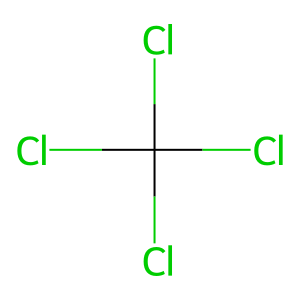

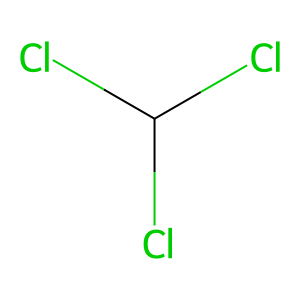

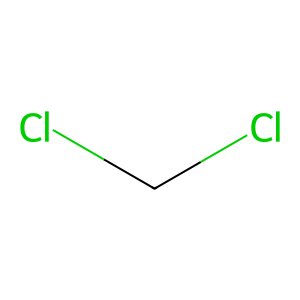

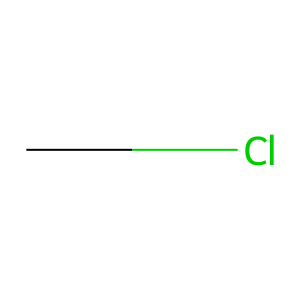

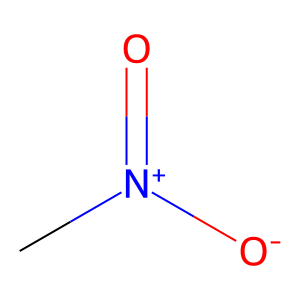

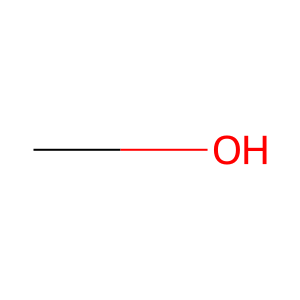

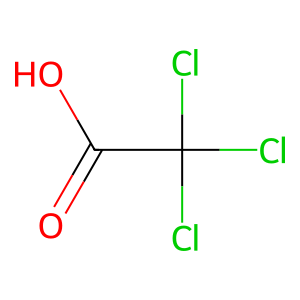

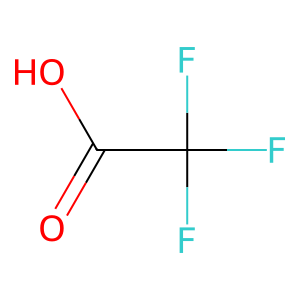

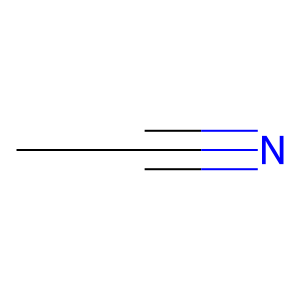

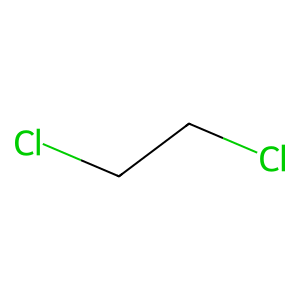

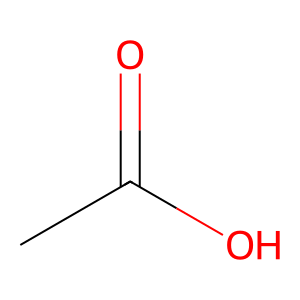

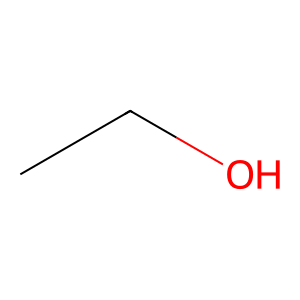

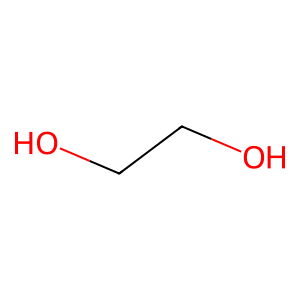

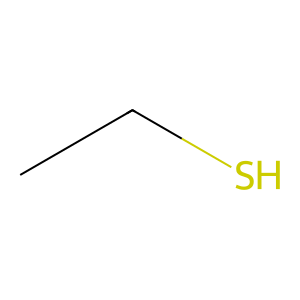

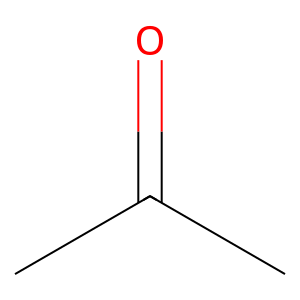

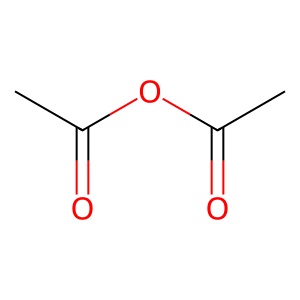

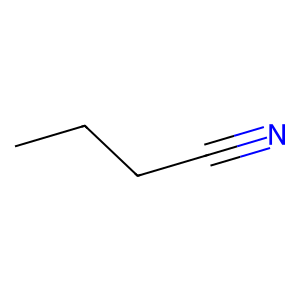

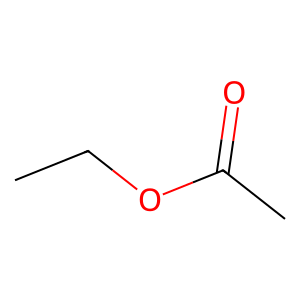

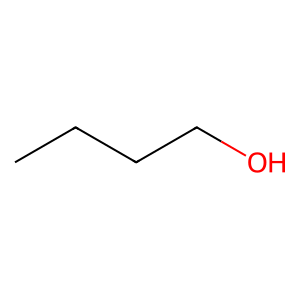

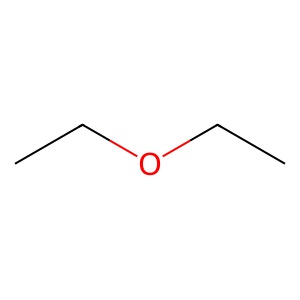

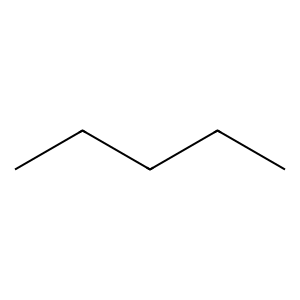

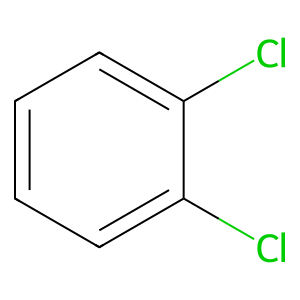

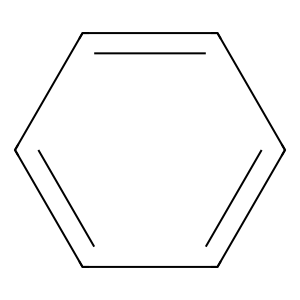

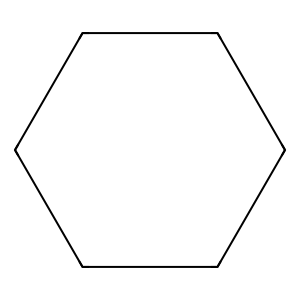

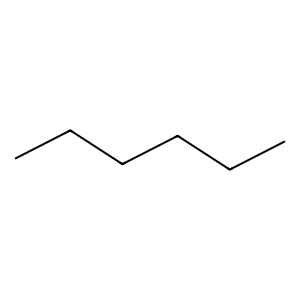

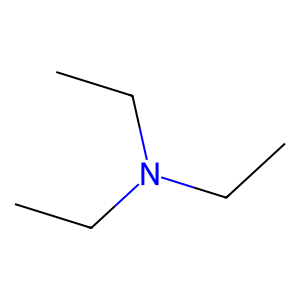

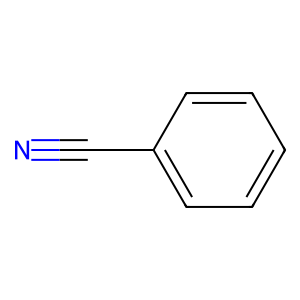

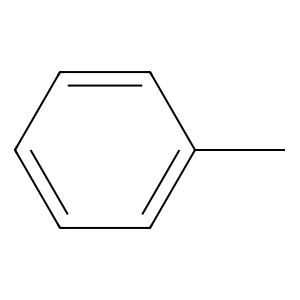

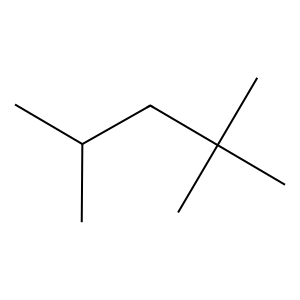

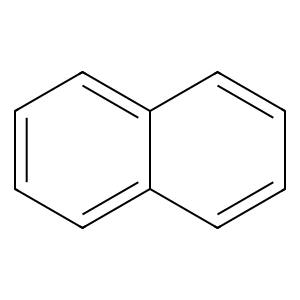

In [ ]:
smiles_list = [
    COMMON_SOLVENTS.get(key, {}).get("SMILES", {}) for key in COMMON_SOLVENTS
]

print(smiles_list)

mols = [Chem.MolFromSmiles(i) for i in smiles_list]

for mol in mols:
    img = MolToImage(mol)
    display(img)